Shape: (545, 13)
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data colum

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



===== Linear Regression =====
Test RMSE: 1324506.96
Test MAE : 970043.40
Test R²  : 0.6529
CV RMSE (mean ± std): 1023579.38 ± 48895.66

===== XGBoost =====
Test RMSE: 1455706.07
Test MAE : 1066423.85
Test R²  : 0.5808
CV RMSE (mean ± std): 1120524.37 ± 83243.51

✅ Best Model: Linear Regression


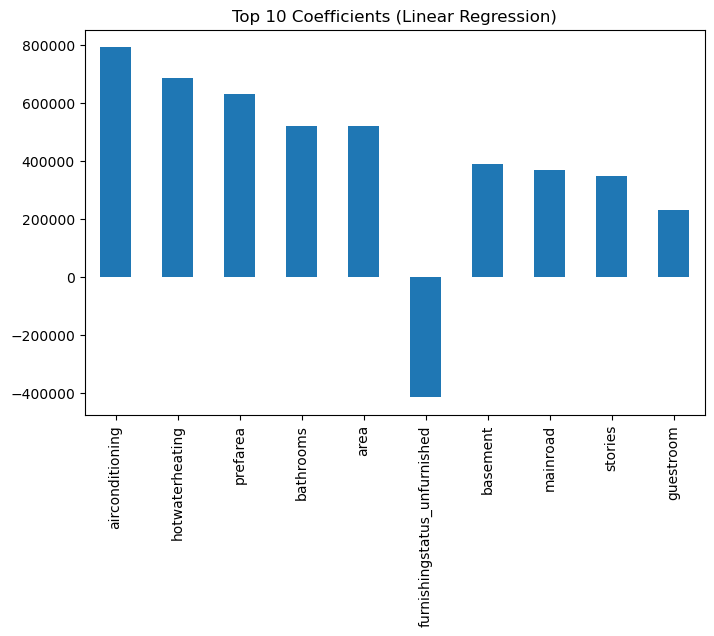


💾 Model saved as best_model.pkl


In [5]:
# ============================================================
# 🏠 Housing Prices Prediction — Full Regression Pipeline
# ============================================================

# 📦 IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pickle

# ============================================================
# 📂 LOAD DATA
# ============================================================
df = pd.read_csv(r"C:\Users\ASUS\Downloads\archive\Housing.csv")
print("Shape:", df.shape)
print(df.head())

# ============================================================
# 🔍 BASIC INFO
# ============================================================
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

# ============================================================
# 🧠 PREPROCESSING
# ============================================================

# Convert binary yes/no columns to numeric
binary_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
for col in binary_cols:
    df[col] = df[col].map({'yes':1, 'no':0})

# One-hot encode furnishingstatus
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

# Split features and target
X = df.drop(columns=['price'])
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Numeric columns to scale
numeric_cols = ['area','bedrooms','bathrooms','stories','parking']

# Standard scaling for numeric columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols)], remainder='passthrough')

# ============================================================
# 🧩 MODEL SETUP
# ============================================================
from xgboost import XGBRegressor

# Linear Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])

# XGBoost (fallback: RandomForest if XGBoost not available)
try:
    xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
except:
    xgb_model = RandomForestRegressor(n_estimators=200, random_state=42)

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgb_model)])

# ============================================================
# 🏋️‍♂️ TRAIN MODELS
# ============================================================
lr_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# ============================================================
# 📊 EVALUATION FUNCTION
# ============================================================
def evaluate_model(name, pipeline, X_tr, X_te, y_tr, y_te):
    y_pred = pipeline.predict(X_te)
    rmse = mean_squared_error(y_te, y_pred, squared=False)
    mae = mean_absolute_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse = np.sqrt(-cross_val_score(pipeline, X_tr, y_tr, 
                                       scoring='neg_mean_squared_error', cv=cv))
    print(f"\n===== {name} =====")
    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test MAE : {mae:.2f}")
    print(f"Test R²  : {r2:.4f}")
    print(f"CV RMSE (mean ± std): {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
    return rmse

rmse_lr = evaluate_model("Linear Regression", lr_pipeline, X_train, X_test, y_train, y_test)
rmse_xgb = evaluate_model("XGBoost", xgb_pipeline, X_train, X_test, y_train, y_test)

# ============================================================
# 🏆 CHOOSE BEST MODEL
# ============================================================
best_pipeline = lr_pipeline if rmse_lr < rmse_xgb else xgb_pipeline
print("\n✅ Best Model:", "Linear Regression" if rmse_lr < rmse_xgb else "XGBoost")

# ============================================================
# 🌟 FEATURE IMPORTANCES / COEFFICIENTS
# ============================================================
numeric_cols = ['area','bedrooms','bathrooms','stories','parking']
other_cols = [c for c in X.columns if c not in numeric_cols]
pipeline_feature_names = numeric_cols + other_cols

model = best_pipeline.named_steps['model']

if hasattr(model, 'feature_importances_'):
    fi = pd.Series(model.feature_importances_, index=pipeline_feature_names).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    fi.head(10).plot(kind='bar')
    plt.title("Top 10 Feature Importances (XGBoost)")
    plt.show()
elif hasattr(model, 'coef_'):
    coef = pd.Series(model.coef_, index=pipeline_feature_names).sort_values(key=abs, ascending=False)
    plt.figure(figsize=(8,5))
    coef.head(10).plot(kind='bar')
    plt.title("Top 10 Coefficients (Linear Regression)")
    plt.show()

# ============================================================
# 💾 SAVE MODEL
# ============================================================
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_pipeline, f)

print("\n💾 Model saved as best_model.pkl")
